# 1. 前言


梯度提升机是集成学习中Boosting这一流派（其它集成学习方法还有bagging、stacking等）的一种方法，boosting流派中另外一种得到广泛应用的是自适应提升法（Adaptive Boost，简称Adaboost）。

XGBoost( eXtreme Gradient Boosting：极限梯度提升)是基于决策树的集成机器学习算法，它以梯度提升（Gradient Boost）为框架，由GBDT发展而来。它的主要目标是提升模型运行的速度和有效性(efficiency)。同样是利用加法模型与前向分步算法实现学习的优化过程，但与GBDT是有区别的，主要包括以下几点：

(1) 目标函数：XGBoost的损失函数添加了正则化项，使用正则用以控制模型的复杂度，正则项里包含了树的叶子节点个数、每个叶子节点权重（叶结点的socre值）的平方和。

(2) 优化方法：GBDT在优化时只使用了一阶导数信息，XGBoost在优化时使用了一、二阶导数信息。

(3) 缺失值处理：XBGoost对缺失值进行了处理，通过学习模型自动选择最优的缺失值默认切分方向。

(4) 防止过拟合: XGBoost除了增加了正则项来防止过拟合,还支持行列采样的方式来防止过拟合。

结果：它可以在最短时间内用更少的计算资源得到更好的结果。

XGBoost被大量运用于竞赛中，比如Kaggle竞赛，在Kaggle2015年公布的29个获胜者中有17个使用了XGBoost，同样在KDDCup2015的竞赛中XGBoost也被大量使用。


本文不涉及更深的理论介绍（感兴趣者可以去读原论文, Ref3提供了一个不错的解读），仅限于简要介绍如何构建你的第一个XGboost应用模型。


## 1.1 安装或更新

要使用XGboost，当然首先要安装XGboost(for use in Python)。如下一键式命令即可。

conda/pip install xgboost

或者如你是要更新的话：

conda update xgboost

or

pip install -upgrade xgboost

XGBoost

XGBoost采用了scikit-learn中通用的封装方式，其使用方法和使用scikit-learn的内置模型是一样的。

# 2. 第一个例子: Predict Onset of Diabetes

在这个例子中，我们使用Pima Indians onset of diabetes dataset，该数据集(csv文件)可以从以下连接下载：(https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv),相应的说明文件：https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names

该数据集描述的是患者所接收的医疗记录，其标签则表示是否患有糖尿病的诊断结果。
该数据集包含8个特征(all numeric-valued)，如下所示：
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
标签为二进制值{0,1}，表示是否患有糖尿病。
   9. Class variable (0 or 1)

从说明文件“pima-indians-diabetes.names.txt”或者UCI Machine Learning Repository website可以获得更加详细的信息。
这个数据集由于其各特征都是数值(numberic)类型，且是一个简单的二分类问题，但是由于它过于简单而且数据集也比较小，所以，不一定是XGboost能够发挥优势的地方。

## 2.1 加载数据

以下用两种方法加载读入csv文件中的数据，一是pandas.read_csv，一是numpy.loadtxt()。两种方法输出的数据格式不一样，前者是Pandas DataFrame，后者是numpy ndarray，两者都可以。后续的fit()等函数对于两者都支持。Pandas读入生成的DataFrame的视觉效果更好一些。

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Bad key text.latex.preview in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You pr

In [2]:
# Read the data with Pandas
df = pd.read_csv('pima-indians-diabetes.csv',header=None) # There is no header row in this csv file.
# X = df[[0,1,2,3,4,5,6,7]]
X_df = df.drop(columns=[8],axis=1) # Throw the column#8 to form train samples. The column#8 is label
Y_df  = df[8]
df

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# Read the data with Numpy
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X_np = dataset[:,0:8]
Y_np = dataset[:,8]
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [4]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

#X,Y = X_df, Y_df # Both are OK!
X,Y = X_np, Y_np

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [5]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

## 2.2 模型训练

XGBoost提供了一个wrapper class，使得其中的模型可以以scikit-learn框架中的分类或者回归模型同样的方式使用。这也意味着XGBoost和scikit-learn库可以无缝结合使用。

XGBoost中的分类模型为XGBClassifier，回归模型为XGBRegressor.本节我们用前者进行分类实验。XGBClassifier有很多参数可以使用，但是作为第一个例子我们尽量使用缺省的参数组合。

In [6]:
model = xgb.XGBClassifier(random_state=1,use_label_encoder=False) # 如果不指定use_label_encoder=False的话会导致警告
model.fit(X_train, y_train)
print(model) # 打印模型信息

[12:20:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


## 2.3 预测和评估

可以用model.score()直接给出该模型分别在训练集和测试集上的预测准确度。

In [7]:
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))

Accuracy over train set:  1.0
Accuracy over test set:  0.7402597402597403


如果想知道针对每个样本的预测结果，则可以使用model.predict()函数。当然也可以使用model.predict_proba()函数得出针对每个样本的软预测结果，即概率性的预测结果，其中包含了预测结果的置信度信息。基于model.predict()调用结果，再调用accuracy_score也同样可以得到accuracy结果，model.score()相当于连续调用model.predict()和accuracy_score()但是没有输出中间的预测结果而已！

In [8]:
# evaluate predictions
from sklearn.metrics import accuracy_score

test_pred_proba = model.predict_proba(X_test)
test_pred = model.predict(X_test)
print(test_pred)
print(test_pred_proba[:5,:])

accuracy = accuracy_score(y_test, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0
 1 0 0 0 0 0]
[[0.9896546  0.01034541]
 [0.00632519 0.9936748 ]
 [0.50282574 0.49717423]
 [0.9918761  0.00812385]
 [0.14539629 0.8546037 ]]
Accuracy: 74.03%


如上所示，软预测结果提供了一些额外的信息。比如说第3个样本，[0.50282574 0.49717423]，这意味着模型对这个样本的class#0和class#1的预测概率几乎相当，这说明本模型对于这个样本没有什么可说瞎蒙了一个而已。很可能在不同随机种子条件下进行训练得到的预测结果就不相同的。

以下把左右代码串在一起构成一个完整pipeline。

In [9]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Read the data with Pandas
df = pd.read_csv('pima-indians-diabetes.csv',header=None) # There is no header row in this csv file.
# X = df[[0,1,2,3,4,5,6,7]]
X = df.drop(columns=[8],axis=1) # Throw the column#8 to form train samples. The column#8 is label
Y = df[8]

# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = xgb.XGBClassifier(random_state=1,use_label_encoder=False)
model.fit(X_train, y_train)
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))

[12:21:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy over train set:  1.0
Accuracy over test set:  0.7402597402597403


## 3 过拟合

从以上结果来看，在训练集上达到了惊人的100%的预测准确度，而在测试集上只有74%，这个是明显的过拟合了。如何解决过拟合问题呢？

过拟合与模型复杂度相关联，要想解消过拟合问题就必须降低模型复杂度。一般来说，梯度提升方法有以下三个参数与模型复杂度相关联：

第一个是树的最大深度max_depth，树的深度越大意味着模型复杂度越高，其计算复杂度（内存需求、计算负荷）也更高。所以减小树的深度有利于解消过拟合问题。

第二个是学习率learning_rate，用于控制每棵树纠正前一棵树的错误的强度。较高的学习率意味着每棵树都可以做出较强的修正，这样模型更加复杂。反过来说，降低学习率有助于降低模型复杂度并减轻过拟合问题。以下我们两种方法都试一试看。

第三个是树的个数，由n_estimators指定。更多的树意味着更高的模型复杂度，因为模型有更多的机会纠正训练集上的错误。

## 3.1 降低学习率

XGBoost的缺省的学习率是0.1，以下我们将学习率将到0.01，训练集上的准确度降维90%，测试集上的准确度提高了2.5个百分点。过拟合现象有一定程度的解消，但是仍然比较严重。如果降到0.05的话，训练集和测试集上的准确度分为变为{88%, 78%}。进一步降低学习率变化不大，看来降低学习率不能完全解决过拟合的问题。

In [10]:
model = xgb.XGBClassifier(random_state=1,learning_rate=0.01,use_label_encoder=False)
model.fit(X_train, y_train)
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))

[12:21:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy over train set:  0.8957654723127035
Accuracy over test set:  0.7662337662337663


## 3.2 减小树的深度

XGBoost的缺省的max_depth为6，以下我们在将学习率固定为0.01的条件下，降低该参数值看看会发生什么。

learning_rate  max_depth  train_accuracy   test_accuracy

 0.01       6       89.5%         76.6%
 
 0.01       3       78.8%         77.6%
 
 0.01       1       75.0%         74.6%
 

看上去减小max_depth不是很有效，虽然max_depth=3在测试集上比max_depth=6要稍微好一些。

In [12]:
model = xgb.XGBClassifier(random_state=1,learning_rate=0.01,max_depth=1, use_label_encoder=False)
model.fit(X_train, y_train)
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))


[12:22:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy over train set:  0.750814332247557
Accuracy over test set:  0.7467532467532467


## 3.3 减小树的个数

XGBoost的缺省的n_estimators为100，以下我们在将学习率固定为0.01，max_depth=3的条件下，降低该参数值看看会发生什么。

n_estimators learning_rate  max_depth  train_accuracy   test_accuracy 

100       0.01       3       78.8%         77.6%

80        0.01       3       78.1%         77.9% 

60        0.01       3       77.8%         77.9% 
 
如上所示，将树的个数降为80时，训练集和测试集上的准确度基本持平了，这个意味着已经很难再得到进一步的改进了。

In [14]:
model = xgb.XGBClassifier(random_state=1,learning_rate=0.01,max_depth=3,n_estimators=60,use_label_encoder=False)
model.fit(X_train, y_train)
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))

[12:23:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy over train set:  0.7785016286644951
Accuracy over test set:  0.7792207792207793


# 4. 归一化有好处吗？

一般来说基于树的模型对于数据的缩放都不敏感，因此数据不需要进行归一化（包括均值归一化和方差归一化）。以下我们也通过实验来确定一下XGBoost分类器模型对于数据归一化是否敏感。

In [15]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 用numpy.loadtxt读取对于做归一化处理更方便
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

# normalization of each feature
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
feature0 = X[:,0]
print(feature0.shape, np.mean(feature0), np.std(feature0))

# split data into train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

model = xgb.XGBClassifier(random_state=1,learning_rate=0.01,max_depth=3,n_estimators=80,use_label_encoder=False)
model.fit(X_train, y_train)
print('Accuracy over train set: ', model.score(X_train, y_train))
print('Accuracy over test set: ', model.score(X_test,y_test))

(768,) -8.789265611615822e-17 1.000000000000002
[12:24:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy over train set:  0.7947882736156352
Accuracy over test set:  0.7792207792207793


# 5. 与其它模型的对比

作为对比，以下我们也用GradientBoostingClassifier和KNeighborsClassifier基于同样的数据进行实验，看看相互之间的性能对比情况。

Accuracy over train set:  0.7638436482084691
Accuracy over test set:  0.7207792207792207


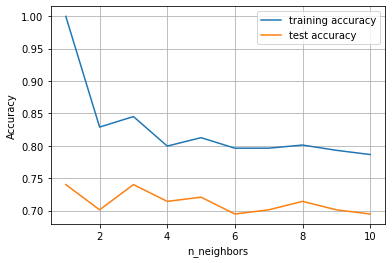

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

gbrt = GradientBoostingClassifier(random_state=1, learning_rate=0.01, max_depth=3, n_estimators=80)
gbrt.fit(X_train,y_train)
print('Accuracy over train set: ', gbrt.score(X_train, y_train))
print('Accuracy over test set: ', gbrt.score(X_test,y_test))

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
 
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.grid()
plt.legend()

In [ ]:
from numpy import loadtxt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

# normalization of each feature
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
feature0 = X[:,0]
print(feature0.shape, np.mean(feature0), np.std(feature0))

# split data into train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
 
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.grid()
plt.legend()

You can learn more about the defaults for the XGBClassifier and XGBRegressor classes in the XGBoost Python scikit-learn API.

You can learn more about the meaning of each parameter and how to configure them on the XGBoost parameters page.

We are now ready to use the trained model to make predictions.

结论是：训练数据的归一化对于XGboost在这个数据集上的表现没有什么影响。

作为对比，我们还要看看，别的一些方法在这个数据集上的表现。当然，这个数据由于比较小，问题也比较简单，不一定是XGboost能够发挥优势的地方。所以如果看到XGboost没有比其它更简单的算法体现出什么优势也不必感到有什么惊讶。

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

# Reference

1. https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

2. https://www.section.io/engineering-education/machine-learning-with-xgboost-and-scikit-learn/

3. https://zhuanlan.zhihu.com/p/75217528

4. Andreas C.Muller, Sarah Guido, Introduction to Machine Leanring with Python（《Python机器学习基础教程》）

5. https://zhuanlan.zhihu.com/p/448086099
